In [2]:
# CATBoost
# This model is supposed to predict the binary label (1/0), attack or not attack
# If (attack == 1) then 
    # Predict what kind of attack it is (Intrusion, fuzzies, exploit,...etc.)

# We're supposed to get better results from this than any of the other models we've used so far. (XGBoost, RF, LR and SVM)

In [3]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Loading the Data
df = pd.read_csv('/kaggle/input/cleaned-logged-cyber-threat-dataset/df_log_clipped.csv')


# Quickly Inspecting the data
df.shape

(2027332, 43)

In [4]:
df.columns.tolist()

['proto',
 'state',
 'dur',
 'sbytes',
 'dbytes',
 'sttl',
 'dttl',
 'sloss',
 'dloss',
 'service',
 'sload',
 'dload',
 'spkts',
 'dpkts',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'smean',
 'dmean',
 'trans_depth',
 'res_bdy_len',
 'sjit',
 'djit',
 'Src_pkt_AT',
 'Dst_pkt_AT',
 'tcprtt',
 'synack',
 'ackdat',
 'is_sm_ips_ports',
 'ct_state_ttl',
 'ct_flw_http_mthd',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'attack_cat',
 'label']

In [5]:
df.head()

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,udp,CON,0.001054,132,164,31,29,0,0,dns,...,0,3,7,1,3,0.693147,1,1,normal,0
1,udp,CON,0.035496,528,304,31,29,0,0,none,...,0,2,4,2,3,0.693147,1,2,normal,0
2,udp,CON,0.001118,146,178,31,29,0,0,dns,...,0,12,8,1,2,0.693147,1,1,normal,0
3,udp,CON,0.001208,132,164,31,29,0,0,dns,...,0,6,9,1,1,0.693147,1,1,normal,0
4,udp,CON,0.001168,146,178,31,29,0,0,dns,...,0,7,9,1,1,0.693147,1,1,normal,0


In [6]:
# Since we're using CATBoost, we don't have to any kinds of encoding to our categorical data.
# Instead, all we gotta do is just define the categroical columns and let the model know, and it should be able to handle it internally. 


# Find all categorical columns automatically
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Detected Categorical Columns: {categorical_cols}")

Detected Categorical Columns: ['proto', 'state', 'service', 'attack_cat']


In [7]:
# Now that we've identified the categorical columns, it's time we let the model know that. 

# Drop the targets from features (proto, state, service); (attack_cat)
X = df.drop(['label', 'attack_cat'], axis=1) 
y = df['label']


# List of categories without the 'attack-cat', because it's a label not a feature
categorical_cols = ['proto', 'state', 'service']


# Train/Test Split the data for our label prediction (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Verify our split works
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Categorical Columns Used: {categorical_cols}")



X_train shape: (1621865, 41)
X_test shape: (405467, 41)
Categorical Columns Used: ['proto', 'state', 'service']


In [8]:
# # # Cell 1: Install and import Optuna
# # # We'll be using optuna optimization; myuch better and faster than grid search

# # Installing optuna
# !pip install optuna --quiet
# !pip install optuna-integration[catboost]

In [9]:
# This cell maximizes over recall (catches all the attacks with recall = 100%)


# # Now, we train the CATBoost for Label (binary) prediction

# import optuna
# from optuna.integration import CatBoostPruningCallback

# # Updated Cell 2 (NO print per trial)

# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 2000),
#         'depth': trial.suggest_int('depth', 4, 12),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
#         'class_weights': [1, trial.suggest_float('class_weight_attack', 1, 10)
# ],
#         'loss_function': 'Logloss',
#         'eval_metric': 'Recall',
#         'task_type': 'GPU',
#         'devices': '0',
#         'cat_features': categorical_cols,
#         'verbose': 0,
#         'random_seed': 42,
#         'early_stopping_rounds': 100
#     }

#     model = CatBoostClassifier(**params)

#     model.fit(
#         X_train, y_train,
#         eval_set=(X_test, y_test)
#     )

#     y_pred = model.predict(X_test)

#     # 🔥 JUST return Recall score — NO printing!
#     from sklearn.metrics import recall_score
#     return recall_score(y_test, y_pred, pos_label=1)


In [15]:
##################################################################################################################################
# This Cell will now try and maximize over f1, this way we could achive some sort of balance between Precision and Recall. 
##################################################################################################################################

# Old Optuna Range:
# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 2000),
#         'depth': trial.suggest_int('depth', 4, 12),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
#         'border_count': trial.suggest_int('border_count', 32, 255),
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#         'random_strength': trial.suggest_float('random_strength', 1.0, 10.0),
#         'class_weights': [1, trial.suggest_float('class_weight_attack', 1, 10)],
#         'loss_function': 'Logloss',
#         'eval_metric': 'F1',
#         'task_type': 'GPU',
#         'devices': '0',
#         'cat_features': categorical_cols,
#         'random_seed': 42,
#         #'verbose': 0  # silent training
#     }


# Reduced Range, based on the results I got from the search above
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1200, 1800),
        'depth': trial.suggest_int('depth', 7, 11),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5.0, 10.0),
        'border_count': trial.suggest_int('border_count', 150, 220),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 0.7),
        'random_strength': trial.suggest_float('random_strength', 5.0, 9.5),
        'class_weights': [1, trial.suggest_float('class_weight_attack', 1.0, 2.0)],
        
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'task_type': 'GPU',
        'devices': '0',
        'cat_features': categorical_cols,
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test))

    y_pred = model.predict(X_test)


    from sklearn.metrics import f1_score

    # ⚡ Calculate F1-Score (for label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
        print(f"✅ Trial {trial.number} finished with Macro F1 = {score:.5f}")

    return f1

# Then outside the function:
import optuna


In [16]:
######################################################################################################################################################
# Updated Cell 3 (Run Optuna + Final Model Automatically): works with the f1 maximizer (needs to be modified a little for the Recall maximizer)
######################################################################################################################################################


# Suppress Optuna logging
# optuna.logging.set_verbosity(optuna.logging.WARNING)

# Create Study
study = optuna.create_study(direction="maximize")

# Run optimization
study.optimize(objective, n_trials=30)

# 🚀 After it's done, rebuild model with best params automatically
print("\n✅ Best Hyperparameters found:")
print(study.best_params)


[I 2025-04-26 22:55:25,192] A new study created in memory with name: no-name-233f0bb2-ad8a-4131-932d-d1c1ec7f1566
[I 2025-04-26 22:57:23,581] Trial 0 finished with value: 0.920750982709805 and parameters: {'iterations': 1387, 'depth': 7, 'learning_rate': 0.07125223166985364, 'l2_leaf_reg': 8.214014766345752, 'border_count': 160, 'bagging_temperature': 0.317984186713161, 'random_strength': 5.9998351930987415, 'class_weight_attack': 1.5785430958439892}. Best is trial 0 with value: 0.920750982709805.
[I 2025-04-26 23:00:12,761] Trial 1 finished with value: 0.9211888782358582 and parameters: {'iterations': 1247, 'depth': 9, 'learning_rate': 0.07795766687947063, 'l2_leaf_reg': 9.019469167720924, 'border_count': 200, 'bagging_temperature': 0.5413925660017483, 'random_strength': 7.330385984397886, 'class_weight_attack': 1.7938025198477567}. Best is trial 1 with value: 0.9211888782358582.
[I 2025-04-26 23:03:14,719] Trial 2 finished with value: 0.9237252658312636 and parameters: {'iterations':


✅ Best Hyperparameters found:
{'iterations': 1750, 'depth': 10, 'learning_rate': 0.07135815451865841, 'l2_leaf_reg': 8.509670107104139, 'border_count': 209, 'bagging_temperature': 0.2035927750913724, 'random_strength': 7.3389164592805, 'class_weight_attack': 1.1142925855388885}


0:	learn: 0.8581239	test: 0.8616180	best: 0.8616180 (0)	total: 115ms	remaining: 3m 21s
100:	learn: 0.9172681	test: 0.9184789	best: 0.9184789 (100)	total: 17.3s	remaining: 4m 42s
200:	learn: 0.9231711	test: 0.9210564	best: 0.9215994 (175)	total: 33.9s	remaining: 4m 21s
300:	learn: 0.9335245	test: 0.9247356	best: 0.9248439 (297)	total: 51s	remaining: 4m 5s
400:	learn: 0.9406093	test: 0.9260929	best: 0.9260929 (400)	total: 1m 8s	remaining: 3m 49s
500:	learn: 0.9460413	test: 0.9262926	best: 0.9266142 (493)	total: 1m 25s	remaining: 3m 33s
600:	learn: 0.9516073	test: 0.9264322	best: 0.9266142 (493)	total: 1m 42s	remaining: 3m 16s
700:	learn: 0.9562231	test: 0.9265679	best: 0.9266592 (617)	total: 2m	remaining: 3m
800:	learn: 0.9601920	test: 0.9271222	best: 0.9274802 (775)	total: 2m 17s	remaining: 2m 43s
900:	learn: 0.9635947	test: 0.9269966	best: 0.9275274 (879)	total: 2m 35s	remaining: 2m 26s
1000:	learn: 0.9673065	test: 0.9269761	best: 0.9275274 (879)	total: 2m 53s	remaining: 2m 9s
1100:	le

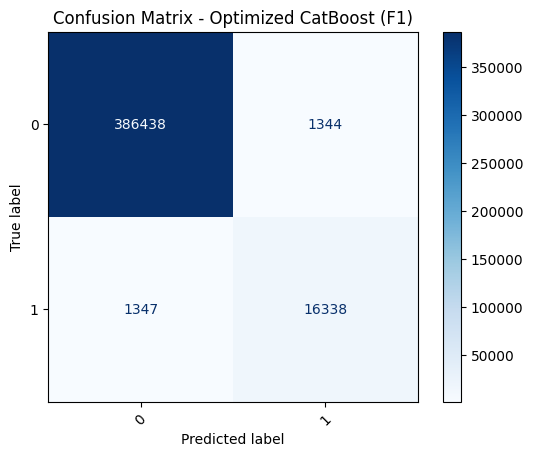

In [18]:
# Now rebuild and retrain the final model
best_params = study.best_params

# ⚡ Fix 'class_weight_attack' ➔ CatBoost expects 'class_weights'
catboost_ready_params = best_params.copy()
catboost_ready_params['class_weights'] = [1, catboost_ready_params.pop('class_weight_attack')]

# ⚡ Update additional fixed parameters
catboost_ready_params.update({
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'task_type': 'GPU',
    'devices': '0',
    'cat_features': categorical_cols,
    'random_seed': 42,
    'verbose': 100
})

# Now create final model
final_model = CatBoostClassifier(**catboost_ready_params)

# Train
final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Final Predictions
y_pred_final = final_model.predict(X_test)

# 📊 Final Classification Report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n📊 Final Classification Report (Optimized CatBoost F1):")
print(classification_report(y_test, y_pred_final))

# 🔵 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Optimized CatBoost (F1)')
plt.grid(False)
plt.show()


In [23]:
import os
import shutil

# Step 1: Create the directory if it doesn't exist
os.makedirs("/kaggle/outputs", exist_ok=True)

# Step 2: Move the file
shutil.copy("/kaggle/working/optimized_catboost_model_label.cbm", "/kaggle/outputs/optimized_catboost_model_label.cbm")

print("✅ Model moved to Outputs!")

✅ Model moved to Outputs!


In [24]:
# from catboost import CatBoostClassifier

# # Load the saved model
# loaded_model = CatBoostClassifier()
# loaded_model.load_model("optimized_catboost_model_label.cbm")

# # Predict using loaded model
# predictions = loaded_model.predict(X_test)


In [25]:
# Now for (Label == 1), we start the categorical classification (attack_cat)
# Therefore, this would be a two stage model. 
# if we use categorical classification on all the data, accuracy will be way off, because of how imbalanced the classes would be. 

In [26]:

import pandas as pd
from sklearn.model_selection import train_test_split



# 📌 Step 1: Filter only rows where label == 1 (attacks)
df_attack = df[df['label'] == 1].copy()

print(f"Filtered dataset shape: {df_attack.shape}")
print(df_attack['attack_cat'].value_counts())


Filtered dataset shape: (88424, 43)
attack_cat
exploits          27436
fuzzers           20965
generic           18860
reconnaissance    10118
dos                5502
analysis           2033
backdoor           1881
shellcode          1458
worms               171
Name: count, dtype: int64


In [50]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 1: Create a merged attack category
def merge_attack_categories(cat):
    if cat in ['exploits', 'fuzzers', 'generic']:
        return cat
    else:
        return 'other'

# 🗂️ Apply merge
df_attack['attack_cat_merged'] = df_attack['attack_cat'].apply(merge_attack_categories)

# Step 2: Prepare X and y for the multiclass attack category classification
X_multi = df_attack.drop(['attack_cat', 'attack_cat_merged', 'label'], axis=1)
y_multi = df_attack['attack_cat_merged']  # use merged target


# ✨ Step 3: Encode y_multi into integers
le = LabelEncoder()
y_multi_encoded = le.fit_transform(y_multi)

# Optional: Save mapping if you want to decode predictions later
attack_cat_mapping = dict(zip(le.classes_, range(len(le.classes_))))

print(f"Attack Categories Mapping: {attack_cat_mapping}")

# Step 4: Split into train/test
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi_encoded, test_size=0.3, random_state=42, stratify=y_multi_encoded
)

# Step 5: Identify categorical columns (for CatBoost input)
categorical_cols_multi = ['proto', 'state', 'service']

print(f"X_train shape: {X_train_m.shape}")
print(f"X_test shape: {X_test_m.shape}")
print(f"Unique encoded attack categories: {len(le.classes_)}")


Attack Categories Mapping: {'exploits': 0, 'fuzzers': 1, 'generic': 2, 'other': 3}
X_train shape: (61896, 41)
X_test shape: (26528, 41)
Unique encoded attack categories: 4


In [51]:
print(df_attack['attack_cat_merged'].value_counts())

attack_cat_merged
exploits    27436
other       21163
fuzzers     20965
generic     18860
Name: count, dtype: int64


0:	learn: 0.7738254	test: 0.7730299	best: 0.7730299 (0)	total: 21.3ms	remaining: 21.2s
100:	learn: 0.8455269	test: 0.8370937	best: 0.8372579 (98)	total: 1.71s	remaining: 15.3s
200:	learn: 0.8566233	test: 0.8437305	best: 0.8438074 (196)	total: 3.32s	remaining: 13.2s
300:	learn: 0.8626242	test: 0.8468986	best: 0.8471908 (283)	total: 4.97s	remaining: 11.5s
400:	learn: 0.8667415	test: 0.8475739	best: 0.8480270 (381)	total: 6.61s	remaining: 9.87s
500:	learn: 0.8709472	test: 0.8489011	best: 0.8489011 (500)	total: 8.26s	remaining: 8.23s
600:	learn: 0.8750271	test: 0.8503486	best: 0.8503486 (600)	total: 9.93s	remaining: 6.59s
700:	learn: 0.8791348	test: 0.8501702	best: 0.8504548 (617)	total: 11.6s	remaining: 4.96s
800:	learn: 0.8825416	test: 0.8503199	best: 0.8504713 (754)	total: 13.3s	remaining: 3.29s
900:	learn: 0.8856712	test: 0.8493898	best: 0.8504713 (754)	total: 14.9s	remaining: 1.63s
999:	learn: 0.8886829	test: 0.8499758	best: 0.8504713 (754)	total: 16.5s	remaining: 0us
bestTest = 0.850

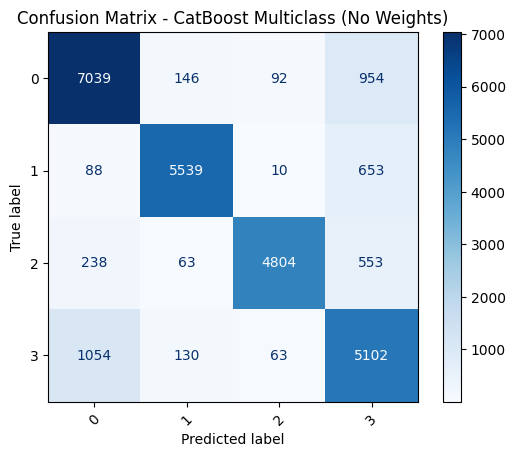

In [55]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🧠 Step 1: Create CatBoostClassifier
model_multi = CatBoostClassifier(
    iterations=1000,
    depth=8,
    learning_rate=0.1,
    loss_function='MultiClass',
    eval_metric='TotalF1',
    task_type='GPU',
    devices='0',
    cat_features=categorical_cols_multi,
    random_seed=42,
    verbose=100
)

# 🚂 Step 2: Train
model_multi.fit(X_train_m, y_train_m, eval_set=(X_test_m, y_test_m))

# 🎯 Step 3: Predict and Evaluate
y_pred_m = model_multi.predict(X_test_m)

print("\n📊 Classification Report (Default CatBoost Multiclass after merging):")
print(classification_report(y_test_m, y_pred_m))

# 📈 Confusion Matrix
cm = confusion_matrix(y_test_m, y_pred_m)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - CatBoost Multiclass (No Weights)')
plt.grid(False)
plt.show()

In [31]:
# Now we use Optuna search for better results

In [67]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1200),
        'depth': trial.suggest_int('depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 8.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 1.0),
        'random_strength': trial.suggest_float('random_strength', 2.0, 10.0),
        'loss_function': 'MultiClass',
        'eval_metric': 'TotalF1',    # ✅ Use this for multiclass F1
        'task_type': 'GPU',
        'devices': '0',
        'cat_features': categorical_cols_multi,
        'random_seed': 42,
        'verbose': 0
    }

    model = CatBoostClassifier(**params)

    model.fit(X_train_m, y_train_m, eval_set=(X_test_m, y_test_m))

    preds = model.predict(X_test_m)

    # Compute macro F1 score manually
    score = f1_score(y_test_m, preds, average='macro')

    print(f"✅ Trial {trial.number} finished with Macro F1 = {score:.5f}")

    return score


In [68]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("\n✅ Best hyperparameters:")
print(study.best_params)

✅ Trial 0 finished with Macro F1 = 0.85807
✅ Trial 1 finished with Macro F1 = 0.84970
✅ Trial 2 finished with Macro F1 = 0.85685
✅ Trial 3 finished with Macro F1 = 0.83666
✅ Trial 4 finished with Macro F1 = 0.85786
✅ Trial 5 finished with Macro F1 = 0.85278
✅ Trial 6 finished with Macro F1 = 0.85208
✅ Trial 7 finished with Macro F1 = 0.85769
✅ Trial 8 finished with Macro F1 = 0.85418
✅ Trial 9 finished with Macro F1 = 0.84645
✅ Trial 10 finished with Macro F1 = 0.85723
✅ Trial 11 finished with Macro F1 = 0.85291
✅ Trial 12 finished with Macro F1 = 0.85854
✅ Trial 13 finished with Macro F1 = 0.85938
✅ Trial 14 finished with Macro F1 = 0.85833
✅ Trial 15 finished with Macro F1 = 0.85829
✅ Trial 16 finished with Macro F1 = 0.85787
✅ Trial 17 finished with Macro F1 = 0.85828
✅ Trial 18 finished with Macro F1 = 0.85472
✅ Trial 19 finished with Macro F1 = 0.85888
✅ Trial 20 finished with Macro F1 = 0.85491
✅ Trial 21 finished with Macro F1 = 0.85826
✅ Trial 22 finished with Macro F1 = 0.8583

In [69]:
print(best_params.keys())

dict_keys(['iterations', 'depth', 'learning_rate', 'l2_leaf_reg', 'border_count', 'bagging_temperature', 'random_strength', 'class_weight_attack', 'loss_function', 'eval_metric', 'task_type', 'devices', 'cat_features', 'random_seed', 'verbose'])


0:	learn: 0.7970543	test: 0.7954719	best: 0.7954719 (0)	total: 46.6ms	remaining: 1m 21s
100:	learn: 0.8396106	test: 0.8317089	best: 0.8318465 (97)	total: 3.33s	remaining: 54.5s
200:	learn: 0.8499047	test: 0.8404664	best: 0.8404664 (200)	total: 6.26s	remaining: 48.2s
300:	learn: 0.8560568	test: 0.8446955	best: 0.8446955 (300)	total: 10.2s	remaining: 49.2s
400:	learn: 0.8604579	test: 0.8471589	best: 0.8471589 (400)	total: 14.3s	remaining: 48.1s
500:	learn: 0.8647211	test: 0.8490664	best: 0.8491233 (492)	total: 18.4s	remaining: 45.8s
600:	learn: 0.8682931	test: 0.8512153	best: 0.8512153 (600)	total: 22.5s	remaining: 42.9s
700:	learn: 0.8716092	test: 0.8522505	best: 0.8522932 (689)	total: 26.6s	remaining: 39.8s
800:	learn: 0.8748015	test: 0.8537954	best: 0.8538321 (791)	total: 30.7s	remaining: 36.3s
900:	learn: 0.8778483	test: 0.8540692	best: 0.8540692 (900)	total: 34.8s	remaining: 32.8s
1000:	learn: 0.8804062	test: 0.8541721	best: 0.8543278 (995)	total: 38.9s	remaining: 29.1s
1100:	learn:

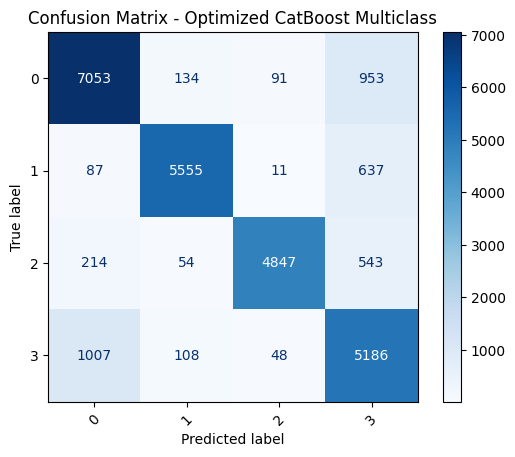

In [70]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🛠 Clean the parameters
params_clean = best_params.copy()

# ❌ Remove invalid keys
params_clean.pop('class_weight_attack', None)  # avoid error if missing
params_clean.pop('loss_function', None)         # remove if included
params_clean.pop('eval_metric', None)            # remove if included
params_clean.pop('task_type', None)
params_clean.pop('devices', None)
params_clean.pop('cat_features', None)
params_clean.pop('verbose', None)
params_clean.pop('random_seed', None)

# ✅ Add valid ones manually
params_clean.update({
    'loss_function': 'MultiClass',
    'eval_metric': 'TotalF1',    # or 'F1'
    'task_type': 'GPU',
    'devices': '0',
    'cat_features': categorical_cols_multi,
    'random_seed': 42,
    'verbose': 100
})

# ✅ Final model
final_model = CatBoostClassifier(**params_clean)

# 🚂 Train
final_model.fit(X_train_m, y_train_m, eval_set=(X_test_m, y_test_m))

# 🎯 Predict
y_pred_final = final_model.predict(X_test_m)

# 📊 Classification Report
print("\n📊 Final Classification Report (Optimized CatBoost Multiclass):")
print(classification_report(y_test_m, y_pred_final))

# 🔵 Confusion Matrix
cm = confusion_matrix(y_test_m, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Optimized CatBoost Multiclass')
plt.grid(False)
plt.show()


In [71]:
# ✅ Save the final optimized multiclass CatBoost model

# 1. Save the model
final_model.save_model("optimized_catboost_multiclass_4class.cbm")
print("✅ Model saved to /kaggle/working/optimized_catboost_multiclass_4class.cbm!")

# 2. Optionally, also save the LabelEncoder mapping (attack_cat_mapping) if you want to decode predictions later
import pickle

with open("attack_cat_labelencoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ LabelEncoder mapping saved to /kaggle/working/attack_cat_labelencoder.pkl!")


✅ Model saved to /kaggle/working/optimized_catboost_multiclass_4class.cbm!
✅ LabelEncoder mapping saved to /kaggle/working/attack_cat_labelencoder.pkl!
